**ABDSynth demo notebook**

This notebook allows the user to test the ABDSynth pre-trained model on a sample patient from the AMOS MR dataset. 

Notes: 
- Make sure to create an appropriate virtual environment according to https://github.com/BBillot/SynthSeg
- You will need sufficient GPU memory to run this notebook, ~40GB. 

Deepa Krishnaswamy and Cosmin Ciausu

Brigham and Women's Hospital

May 2025

If you haven't already, clone the SynthSeg repository. 

In [1]:
!git clone https://github.com/BBillot/SynthSeg.git

Cloning into 'SynthSeg'...
remote: Enumerating objects: 2479, done.
remote: Counting objects: 100% (683/683), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 2479 (delta 613), reused 538 (delta 538), pack-reused 1796 (from 1)
Receiving objects: 100% (2479/2479), 120.57 MiB | 64.61 MiB/s, done.
Resolving deltas: 100% (1614/1614), done.


Import the necessary packages. 

In [ ]:
import os
import sys
import nibabel as nib 
import numpy as np 
import SimpleITK as sitk 
import json
import matplotlib.pyplot as plt

from SynthSeg.predict import predict as synthseg_predict

curr_path = os.getcwd()
sys.path.insert(0, os.path.join(curr_path, 'SynthSeg'))

Then we download the model weights from github release attachments. 

In [21]:
!curl -f -L -O https://github.com/deepakri201/ABDSynth/releases/download/v1.0.0/dice_100.h5 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  151M  100  151M    0     0  57.4M      0  0:00:02  0:00:02 --:--:-- 72.8M


Let's set up the inputs and outputs. 

In [3]:
# inputs 
model_weights_filename = os.path.join(curr_path, 'dice_100.h5')
path_images = os.path.join(curr_path, 'data')
path_images_filename = os.path.join(curr_path, 'data', 'amos_0540.nii.gz')
path_gt_label_filename = os.path.join(curr_path, 'data', 'amos_0540_label.nii.gz')
labels_segmentation_npy_filename = os.path.join(curr_path, 'npy', 'synthseg_segmentation_labels.npy')
# output folder 
path_segmentations = os.path.join(curr_path, 'output')
path_segmentations_filename = os.path.join(curr_path, 'output', 'amos_0540_synthseg.nii.gz')

assert(os.path.exists(model_weights_filename))
assert(os.path.exists(path_images))
assert(os.path.exists(path_images_filename))
assert(os.path.exists(labels_segmentation_npy_filename))

Now we run the prediction. 

In [25]:
# predict 
synthseg_predict(path_images=path_images_filename,
                path_segmentations=path_segmentations_filename,
                path_model=model_weights_filename,
                labels_segmentation=labels_segmentation_npy_filename,
                target_res=1.5,
                gradients=False,
                flip=False,
                sigma_smoothing=0,
                keep_biggest_component=True,
                n_levels = 5,
                nb_conv_per_level = 2,
                conv_size = 3,
                unet_feat_count = 24,
                activation = 'elu',
                feat_multiplier = 2,
                verbose=True)

predicting 1/1


The predicted segmentation has isotropic spacing of 1.5mm. So we need to resample it back to the original spacing of the volume. 

In [ ]:
# Load the prediction 
pred_nii = nib.load(path_segmentations_filename)
image = pred_nii.get_fdata().astype(np.float32)
original_size = image.shape
original_spacing = pred_nii.header['pixdim'][1:4].astype(np.float32)
original_affine = pred_nii.affine
original_origin = original_affine[:3, 3]

print('original_size:', original_size)
print('original_spacing:', original_spacing)
print('original_origin: ' + str(original_origin))

# Load the reference image (for desired size and spacing)
amos_nii = nib.load(path_images_filename)
new_size = np.array(amos_nii.header['dim'][1:4], dtype=np.uint32).tolist()
new_spacing = amos_nii.header['pixdim'][1:4].astype(np.float32).tolist()
print('new_size:', new_size)
print('new_spacing:', new_spacing)

# Load the reference image as an ITK image 
image_sitk = sitk.ReadImage(path_segmentations_filename)

# Resample
resample_filter = sitk.ResampleImageFilter()
resample_filter.SetInterpolator(sitk.sitkNearestNeighbor)
resample_filter.SetOutputSpacing(new_spacing)
resample_filter.SetSize(new_size)
resample_filter.SetOutputDirection(image_sitk.GetDirection())
resample_filter.SetOutputOrigin(image_sitk.GetOrigin())
resample_filter.SetOutputPixelType(image_sitk.GetPixelID())
resample_filter.SetTransform(sitk.Transform())
image_resampled_sitk = resample_filter.Execute(image_sitk)

# Print final dimensions and spacing
print('resampled_size:', image_resampled_sitk.GetSize())
print('resampled_spacing:', image_resampled_sitk.GetSpacing())
print('resampled_origin: ' + str(image_resampled_sitk.GetOrigin()))

# Save the resampled image as a nifti file 
sitk.WriteImage(image_resampled_sitk, os.path.join(curr_path, 'output', 'amos_0540_synthseg_resampled.nii.gz'))


original_size: (251, 250, 134)
original_spacing: [1.5 1.5 1.5]
original_origin: [-167.11459351 -187.43824768  -85.0578537 ]
new_size: [192, 192, 100]
new_spacing: [1.953125, 1.953125, 2.0]
resampled_size: (192, 192, 100)
resampled_spacing: (1.953125, 1.953125, 2.0)
resampled_origin: (167.11459350585938, 187.43824768066406, -85.05785369873047)


Let's also load the ground truth segmentation, the predicted segmention and the original image. We have to change the labels in the ground truth segmentation to match the labels from the predicted segmentation. 

In [ ]:
# Load the ground truth segmentation 
gt_nii = nib.load(path_gt_label_filename)
gt = gt_nii.get_fdata()
print('gt: ' + str(gt.shape))

# Load the predicted segmentation as nifti 
pred = sitk.GetArrayFromImage(image_resampled_sitk) 
pred = np.moveaxis(pred,0,2)
pred = np.swapaxes(pred,0,1)
print('pred: ' + str(pred.shape))

# Load the original image as nifti 
im_nii = nib.load(path_images_filename)
im = im_nii.get_fdata()
print('im: ' + str(im.shape))

# Modify the labels of the ground truth segmentation to match the ones from the predicted segmentation 

# Load the mapping from AMOS 
amos_dataset_json = os.path.join(curr_path, 'data', 'dataset.json')
with open(amos_dataset_json, 'r') as file:
    amos_data = json.load(file)
amos_labels_mapping = amos_data['labels']
print('amos_labels_mapping: ' + str(amos_labels_mapping))

# For ABDSynth, we use the mapping from TotalSegmentator CT 
# We manually define it here, the ones that overlap with AMOS. 
ABDSynth_labels_mapping = {'1': "spleen",
                           '2': "kidney_right",
                           '3': "kidney_left",
                           '4': "gallbladder",
                           '5': "liver",
                           '6': "stomach",
                           '10': "pancreas",
                           '11': "adrenal_gland_right",
                           '12': "adrenal_gland_left",
                           '56': "duodenum"}
print('ABDSynth_labels_mapping: ' + str(ABDSynth_labels_mapping))

# Map the names from AMOS to ABDSynth, and get the corresponding labels 
AMOS_to_ABDSynth_names_mapping = {'spleen': 'spleen', 
                                  'right kidney': 'kidney_right', 
                                  'left kidney': 'kidney_left', 
                                  'gall bladder': 'gallbladder', 
                                  'liver': 'liver', 
                                  'stomach': 'stomach', 
                                  'pancreas': 'pancreas',
                                  'right adrenal gland': 'adrenal_gland_right', 
                                  'left adrenal gland': 'adrenal_gland_left', 
                                  'duodenum': 'duodenum'}
print('AMOS_to_ABDSynth_names_mapping: ' + str(AMOS_to_ABDSynth_names_mapping))

# Map the AMOS labels 
# Step 1: Reverse amos_labels_mapping to get {name: label}
amos_name_to_label = {v: int(k) for k, v in amos_labels_mapping.items()}
# Step 2: Reverse ABDSynth_labels_mapping to get {name: label}
abdsynth_name_to_label = {v: int(k) for k, v in ABDSynth_labels_mapping.items()}
# Step 3: Create final remap dictionary from AMOS label -> ABDSynth label
amos_to_abdsynth_label_remap = {}
for amos_name, abdsynth_name in AMOS_to_ABDSynth_names_mapping.items():
    amos_label = amos_name_to_label[amos_name]
    abdsynth_label = abdsynth_name_to_label[abdsynth_name]
    amos_to_abdsynth_label_remap[amos_label] = abdsynth_label
print("AMOS to ABDSynth label remapping:")
print(amos_to_abdsynth_label_remap)

# Modify the AMOS gt segmentation to get matching labels and save 
gt_remapped = np.zeros_like(gt, dtype=np.uint8)
for amos_label, abdsynth_label in amos_to_abdsynth_label_remap.items():
    gt_remapped[gt == amos_label] = abdsynth_label
gt_remapped_nii = nib.Nifti1Image(gt_remapped, affine=gt_nii.affine, header=gt_nii.header)
nib.save(gt_remapped_nii, os.path.join(curr_path, 'output', 'amos_0540_label_remapped.nii.gz'))


gt: (192, 192, 100)
pred: (192, 192, 100)
im: (192, 192, 100)
amos_labels_mapping: {'0': 'background', '1': 'spleen', '2': 'right kidney', '3': 'left kidney', '4': 'gall bladder', '5': 'esophagus', '6': 'liver', '7': 'stomach', '8': 'arota', '9': 'postcava', '10': 'pancreas', '11': 'right adrenal gland', '12': 'left adrenal gland', '13': 'duodenum', '14': 'bladder', '15': 'prostate/uterus'}
ABDSynth_labels_mapping: {'1': 'spleen', '2': 'kidney_right', '3': 'kidney_left', '4': 'gallbladder', '5': 'liver', '6': 'stomach', '10': 'pancreas', '11': 'adrenal_gland_right', '12': 'adrenal_gland_left', '56': 'duodenum'}
AMOS_to_ABDSynth_names_mapping: {'spleen': 'spleen', 'right kidney': 'kidney_right', 'left kidney': 'kidney_left', 'gall bladder': 'gallbladder', 'liver': 'liver', 'stomach': 'stomach', 'pancreas': 'pancreas', 'right adrenal gland': 'adrenal_gland_right', 'left adrenal gland': 'adrenal_gland_left', 'duodenum': 'duodenum'}
AMOS to ABDSynth label remapping:
{1: 1, 2: 2, 3: 3, 4: 4

Now let's compare the ground truth segmentation and the ABDSynth predictions. 

/tmp/ipykernel_4085/1697375208.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('tab20')


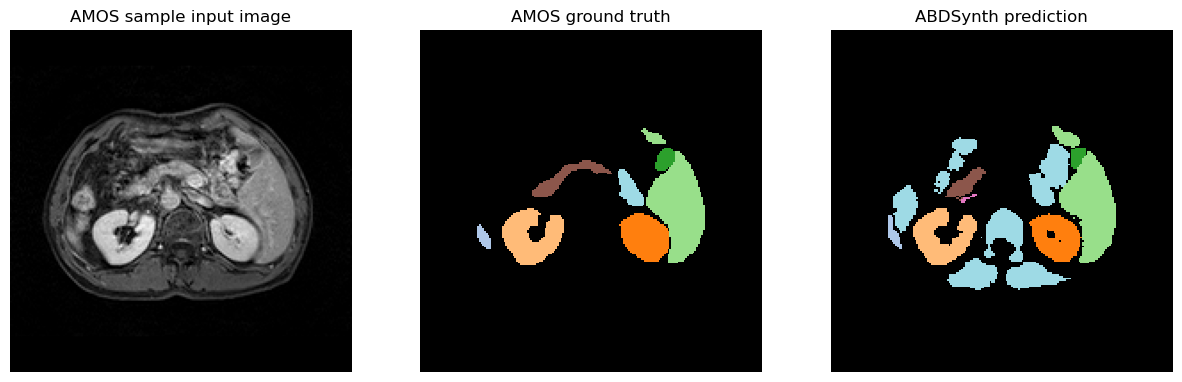

In [64]:
axial_slice = 40
im_axial_slice = im[:,:,axial_slice]
gt_axial_slice = gt_remapped[:,:,axial_slice]
pred_axial_slice = pred[:,:,axial_slice]

from matplotlib.colors import ListedColormap

# Build a colormap 
base_cmap = plt.cm.get_cmap('tab20') 
max_label = int(max(np.max(gt), np.max(pred)))
# Assign black to background (label 0), then colors for 1 to max_label
colors = [(0, 0, 0)] + [base_cmap(i)[:3] for i in range(1, max_label + 1)]
cmap = ListedColormap(colors)

# Plot 
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(im_axial_slice.T, cmap='gray', origin='lower')
axs[0].set_title("AMOS sample input image")
axs[0].axis('off')
axs[1].imshow(gt_axial_slice.T, cmap=cmap, vmin=0, vmax=max_label, origin='lower', interpolation='nearest')
axs[1].set_title("AMOS ground truth")
axs[1].axis('off')
axs[2].imshow(pred_axial_slice.T, cmap=cmap, vmin=0, vmax=max_label, origin='lower', interpolation='nearest')
axs[2].set_title("ABDSynth prediction")
axs[2].axis('off')

plt.show()
